![title](figures/title.png)

# Introduction

IRIS-HEP (Institute for Research and Innovation in Software for High Energy Physics) is a software institute comprising 16 U.S. institutions, primarily from US CMS and US ATLAS institutes, that develops state-of-the-art software cyberinfrastructure for the High-Luminosity Large Hadron Collider at CERN.

IRIS-HEP has various components: Analysis Systems, Data Organization, Management and Access, Innovative Algorithms, Scalable Systems Laboratory, etc.

Many of these components are designed to improve user analysis workflow with the following keywords: Python ecosystem, industry/ML-friendly tools, experiment-agnostic, better UI/UX, etc.

This notebook showcases most of these components through an example ttbar analysis using CMS Open Data.

# Disclaimer

- This notebook is primarily based on the materials shown at the latest US CMS/IRIS-HEP Analysis Software Training 2025 on May 19-20, 2025 (https://indico.cern.ch/event/1509580/)
- Since I'm not a member of CMS, experiment specific details might not be correct :-)


# Analysis Grand Challenge: CMS Open Data $t\bar{t}$

We'll base this on a few sources:
- https://github.com/iris-hep/analysis-grand-challenge/tree/main/analyses/cms-open-data-ttbar (AGC, of course)
- https://github.com/alexander-held/CompHEP-2023-AGC (contains a simplified version of AGC)
- https://github.com/nsmith-/TTGamma_LongExercise/ (credit Nick Smith for helpful examples of the new API)
- (and if time allows, weight features: https://github.com/CoffeaTeam/coffea/blob/backports-v0.7.x/binder/accumulators.ipynb / https://coffeateam.github.io/coffea/api/coffea.analysis_tools.Weights.html#coffea.analysis_tools.Weights.partial_weight)

We are using [2015 CMS Open Data](https://cms.cern/news/first-cms-open-data-lhc-run-2-released) in this demonstration to showcase an analysis pipeline.
This is a **technical demonstration**. We are including the relevant workflow aspects that physicists need in their work, but we are not focusing on making every piece of the demonstration physically meaningful. This concerns in particular systematic uncertainties: we capture the workflow, but the actual implementations are more complex in practice. If you are interested in the physics side of analyzing top pair production, check out the latest results from [ATLAS](https://twiki.cern.ch/twiki/bin/view/AtlasPublic/TopPublicResults) and [CMS](https://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/)!

This notebook implements most of the analysis pipeline shown in the following picture, using the tools also mentioned there:
![ecosystem visualization](figures/pipe.001.jpeg)

This version also includes the Combine tool to perform model building ans statistical inference. Despite not strictly being part of the ecosystem, it is widely used in the CMS collaboration, so in this tutorial we will see an example of statistical inference performed with it.

# Columnar analysis and Awkward Array

"Columnar" is a term that tends to get overloaded, and I’ve used it in two distinct ways:

- Data layout: organizing data in memory or on disk to enable faster, selective readout. (In fact, some types of TTree data have been stored this way since 1995.)
- Array-oriented computation: performing operations directly on entire arrays of data, rather than processing one value at a time in a loop. In other words — no for loops!

Of these, only the second meaning directly affects physicists writing analysis code.

That’s why I prefer to call it "array-oriented programming" — it’s a programming paradigm, much like "imperative" or "functional," describing how you think about and organize your code.

<br>

**Imperative**

In [1]:
original = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

result = []
for x in original:
    result.append(x**2)

result

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

<br>

**Functional**

In [2]:
original = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

result = [x**2 for x in original]

result

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

<br>

**Array-oriented**

In [3]:
import numpy as np

In [4]:
original = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

result = original**2

result

array([  1,   4,   9,  16,  25,  36,  49,  64,  81, 100])

<br>

There are two fundamental concepts you need to understand in the array programming: **axis** and **slice**

Let's open a ttbar MC NanoAOD file.

In [2]:
ttbar_file = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/"\
    "TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_"\
    "mcRun2_asymptotic_v12_ext4-v1_80000_0007.root"

In [1]:
import awkward as ak

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

import warnings
warnings.filterwarnings("ignore")
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here

In [7]:
%%time

events = NanoEventsFactory.from_root({ttbar_file: "Events"}, schemaclass=NanoAODSchema, mode="virtual").events()

CPU times: user 294 ms, sys: 25.2 ms, total: 319 ms
Wall time: 4.9 s


<br>

Let's read Electron pt.

In [8]:
ak.materialize(events.Electron.pt)

<Array [[], [], [], ..., [], [34.3], [23.8]] type='225000 * var * float32[p...'>

Electron pt is represented by a 2D array with variable-length nested array. 

Almost always, `axis=0` is the *events* axis (collision events) and `axis=1` is the *particle* axis (electrons, muons, jets, ...)

Let's check the number of events:

In [11]:
ak.num(events.Electron, axis=0)

array(225000)

Now check how many electrons in each event by passing `axis=1`

In [29]:
ak.num(events.Electron, axis=1)

<Array [0, 0, 0, 0, 3, 0, 0, 2, ..., 1, 1, 3, 1, 0, 1, 1] type='225000 * int64'>

<br>

Slicing (or filtering) of an array requires a boolean array of the same shape.

In [39]:
boolean_mask = events.Electron.pt > 50
boolean_mask

<Array [[], [], [], ..., [], [False], [False]] type='225000 * var * bool[pa...'>

In [40]:
events.Electron.pt[boolean_mask]

<Array [[], [], [], [], ..., [], [], [], []] type='225000 * var * float32[p...'>

Note that the slicing affects only `axis=1` (particle axis) and not `axis=0` (event axis). The array still has 225k events.

#### Let's have a look into a practical example

<img src="figures/ttbar.png" width="400">

- Basic kinematic selections on electron, muon and jets
- Select events with 1 lepton
- Select events with at least 4 jets
- Select events with at least 2 b-tagged jets
- Construct tri-jet objects from all jets in each event
- Select tri-jet candidates with at least one b-tagged jet
- Return mass of a tri-jet candidate with the largest pT

Thus, poor man's top mass reconstruction :-)

In [4]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electron[(events.Electron.pt > 30) & (np.abs(events.Electron.eta) < 2.1)]
    selected_muons = events.Muon[(events.Muon.pt > 30) & (np.abs(events.Muon.eta) < 2.1)]
    selected_jets = events.Jet[(events.Jet.pt > 25) & (np.abs(events.Jet.eta) < 2.4)]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)

    # apply filters
    selected_jets = selected_jets[event_filters]

    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    return trijet_mass
    # return ak.flatten(trijet_mass)

In [6]:
%%time

reconstructed_top_mass = calculate_trijet_mass(events)
reconstructed_top_mass

CPU times: user 149 ms, sys: 29.1 ms, total: 178 ms
Wall time: 176 ms


<Array [126, 146, 150, 307, ..., 183, 189, 141] type='38167 * ?float32[para...'>

What we have here is the 1D array of reconstructed top mass of 38k events (out of 225k events). In terms of data size, 553MB to 458kB.

[Awkward array API documentation](https://awkward-array.org/doc/main/reference/index.html)

Complete columnar/awkward notebook can be found [here](https://github.com/iris-hep/uscms-idap-training/tree/main/columnar).

<br>

# Data visualization

`hist` package for histogramming (including manipulations) and `mplhep` for plotting

#### hist

- Python go to one-stop for histogramming
- Extends boost-histogram (Python binding for C++ `Boost::Histogram` library — *FAST*)
- Shortcuts for convenience and interactive plotting/fitting

#### mplhep

- Built on top of `matplotlib`
- Extends functionality to easily plot histograms from various inputs
- Holds style sheets for easy experiment specific style application

In [20]:
import hist

In [21]:
hist_reco_mtop = hist.Hist.new.Reg(16, 0, 375, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)

In [25]:
type(hist_reco_mtop)

hist.hist.Hist

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x31dbc9090>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

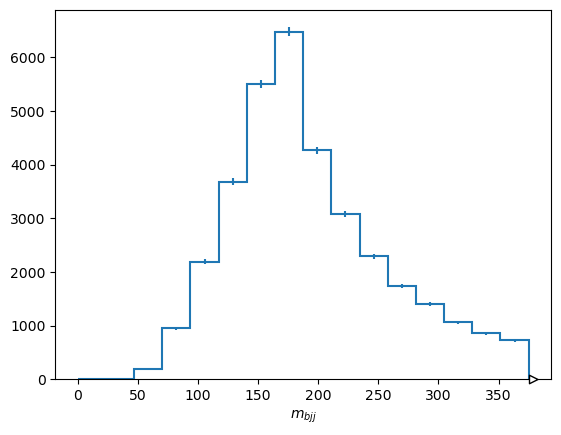

In [26]:
# visualize
artists = hist_reco_mtop.plot()
artists

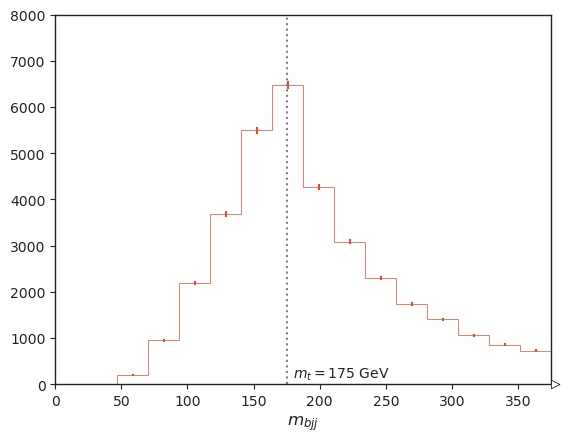

In [19]:
# and annotate the visualization
ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175, 0, 10000, colors=["grey"], linestyle="dotted")
ax.text(180, 150, "$m_{t} = 175$ GeV")
ax.set_xlim([0, 375])
ax.set_ylim([0, 8000])

fig.savefig("figures/trijet_mass.png", dpi=300)
fig

In [31]:
import mplhep

mplhep.style.use([mplhep.style.CMS, {"figure.figsize": (8, 6)}])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x31de7a0d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

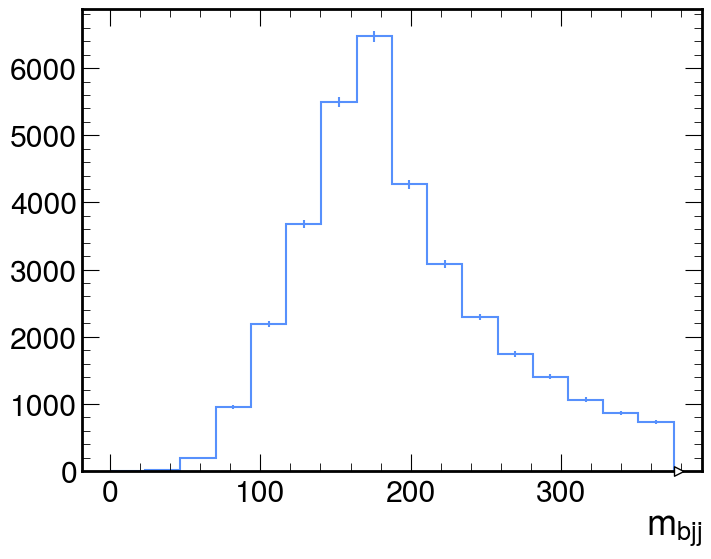

In [32]:
mplhep.histplot(H=hist_reco_mtop)

# coffea columnar analysis framework

In [46]:

import coffea


from dask.distributed import Client
import matplotlib.pyplot as plt

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.processor import ProcessorABC, Runner, DaskExecutor
from coffea.analysis_tools import PackedSelection
import correctionlib

import utils
from utils.systematics import rand_gauss
utils.plotting.set_style()

from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers=3, threads_per_worker=1)
client = Client(cluster)

ndcctools.taskvine module not available
awkward: 2.8.5
uproot: 5.6.3
hist: 2.8.1
coffea: 2025.7.1


In [28]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 3,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65455,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:65466,Total threads: 1
Dashboard: http://127.0.0.1:65468/status,Memory: 5.33 GiB
Nanny: tcp://127.0.0.1:65458,


## Time for coffea

We'll first write the functions to compute the observable and do the histogramming using `awkward` and `hist` again

In [20]:
B_TAG_THRESHOLD = 0.5
cset = correctionlib.CorrectionSet.from_file("corrections.json")

# perform object selection
def object_selection(elecs, muons, jets):
    electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
    muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                 (muons.pfRelIso04_all < 0.15))
    jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

    # Only keep objects that pass our requirements
    elecs = elecs[electron_reqs]
    muons = muons[muon_reqs]
    jets = jets[jet_reqs]

    return elecs, muons, jets


# event selection for 4j1b and 4j2b
def region_selection(elecs, muons, jets):
    ######### Store boolean masks with PackedSelection ##########
    selections = PackedSelection(dtype='uint64')
    # Basic selection criteria
    selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
    selections.add("atleast_4j", ak.num(jets) >= 4)
    selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
    selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
    # Complex selection criteria
    selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
    selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

    return selections


# observable calculation for 4j2b
def calculate_m_reco_top(jets):
    # reconstruct hadronic top as bjj system with largest pT
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2,
                                    np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass)

    return observable


class create_histograms(ProcessorABC):
    # create histograms with observables
    def process(self, events):
        hist_4j1b = (
            hist.Hist.new.Reg(11, 110, 550, name="HT", label=r"$H_T$ [GeV]")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )
    
        hist_4j2b = (
            hist.Hist.new.Reg(11, 110, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )
    
        hist_dict = {"4j1b": hist_4j1b, "4j2b": hist_4j2b}
    
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        #process_label = events.metadata["process_label"]  # nicer LaTeX labels
    
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
    
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = rand_gauss(events.Jet.pt)
    
        syst_variations = ["nominal"]
        jet_kinematic_systs = ["pt_scale_up", "pt_res_up"]
        event_systs = [f"btag_var_{i}" for i in range(4)]
        if process == "wjets":
            event_systs.append("scale_var")
        
        if variation == "nominal":
            syst_variations.extend(jet_kinematic_systs)
            syst_variations.extend(event_systs)
        
        for syst_var in syst_variations:
            elecs = events.Electron
            muons = events.Muon
            jets = events.Jet
    
            if syst_var in jet_kinematic_systs:
                jets["pt"] = jets.pt * events[syst_var]
        
            elecs, muons, jets = object_selection(elecs, muons, jets)
    
            # region selection
            selections = region_selection(elecs, muons, jets)
    
            for region in hist_dict:
                selection = selections.all(region)
                region_jets = jets[selection]
                region_weights = ak.ones_like(ak.num(region_jets, axis=1)) * xsec_weight
                if region == "4j1b":
                    observable = ak.sum(region_jets.pt, axis=-1)
                elif region == "4j2b":
                    observable = calculate_m_reco_top(region_jets)
                syst_var_name = f"{syst_var}"
                if syst_var in event_systs:
                    for i_dir, direction in enumerate(["up", "down"]):
                        if syst_var == "scale_var":
                            wgt_variation = cset["event_systematics"].evaluate("scale_var", direction, region_jets.pt[:, 0])
                        elif syst_var.startswith("btag_var"):
                            i_jet = int(syst_var.rsplit("_",1)[-1])
                            wgt_variation = cset["event_systematics"].evaluate("btag_var", direction, region_jets.pt[:,i_jet])
                        syst_var_name = f"{syst_var}_{direction}"
                        hist_dict[region].fill(
                            observable,
                            process=process,
                            variation=syst_var_name,
                            weight=region_weights * wgt_variation,
                        )
                else:
                    if variation != "nominal":
                        syst_var_name = variation
                    hist_dict[region].fill(
                        observable,
                        process=process,
                        variation=syst_var_name,
                        weight=region_weights,
                    )
    
        return {events.metadata["dataset"]: hist_dict}

    def postprocess(self, accumulator):
        pass

and prepare the fileset we need. More information on how the dataset was prepared can be found [here](https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/ttbar_analysis_pipeline.ipynb).

In [39]:
# fileset preparation
N_FILES_MAX_PER_SAMPLE = 1
# compared to coffea 0.7: list of file paths becomes list of dicts (path: trename)
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE)

# fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}  # to only process nominal ttbar
# fileset

In [42]:
fileset.keys()

dict_keys(['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal'])

In [43]:
fileset['ttbar__nominal']

{'files': {'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root': 'Events'},
 'metadata': {'process': 'ttbar',
  'variation': 'nominal',
  'nevts': 1334428,
  'xsec': 729.84,
  'process_label': '$t\\bar{t}$'}}

In [22]:
# Define Runner
run = Runner(
    DaskExecutor(client=client, compression=None),
    chunksize=250_000,
    skipbadfiles=True,
    schema=NanoAODSchema,
    savemetrics=True
)

In [23]:
%%time
# pre-process
samples = run.preprocess(fileset, treename="Events") # treename not needed with coffea master branch

CPU times: user 96 μs, sys: 10 μs, total: 106 μs
Wall time: 107 μs


and then we can finally execute

In [25]:
%%time
# execute
tmp, report = run(samples, processor_instance=create_histograms())
# sort the key order to be the same as the initial fileset
out = {key: tmp[key] for key in fileset}
sorted(report["columns"])

[                                        ] | 2% Completed |  5.8s

/Users/kc43627/Work/Seminar/14Aug2025_고려대/uscms-idap-training/agc/.pixi/envs/default/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/kc43627/Work/Seminar/14Aug2025_고려대/uscms-idap-training/agc/.pixi/envs/default/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/Users/kc43627/Work/Seminar/14Aug2025_고려대/uscms-idap-training/agc/.pixi/envs/default/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/Users/kc43627/Work/Seminar/14Aug2025_고려대/uscms-idap-training/agc/.pixi/envs/default/lib/python3.13/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for FatJe

CPU times: user 16 s, sys: 6.68 s, total: 22.7 s% Completed |  4min 18.9s
Wall time: 4min 18s


['Electron_cutBased',
 'Electron_eta',
 'Electron_pt',
 'Electron_sip3d',
 'Jet_btagCSVV2',
 'Jet_eta',
 'Jet_jetId',
 'Jet_mass',
 'Jet_phi',
 'Jet_pt',
 'Muon_eta',
 'Muon_pfRelIso04_all',
 'Muon_pt',
 'Muon_sip3d',
 'Muon_tightId',
 'nElectron',
 'nJet',
 'nMuon']

Notice that the columns being read are the same that `dak.necessary_columns` reported in the `dask-awkward` case

To visualize the results, we need to first stack the serperate histograms that were computed individually

In [26]:
# stack all the histograms together (we processed each sample separately)
full_histogram_4j1b = sum([v["4j1b"] for v in out.values()])
full_histogram_4j2b = sum([v["4j2b"] for v in out.values()])

In [27]:
# dump for stats inference with also pseudodata
for region, histogram in [("bin4j1b", full_histogram_4j1b), ("bin4j2b", full_histogram_4j2b)]:
    utils.file_output.save_histograms(histogram, f"all_histograms_fps{N_FILES_MAX_PER_SAMPLE}_{region}.root")

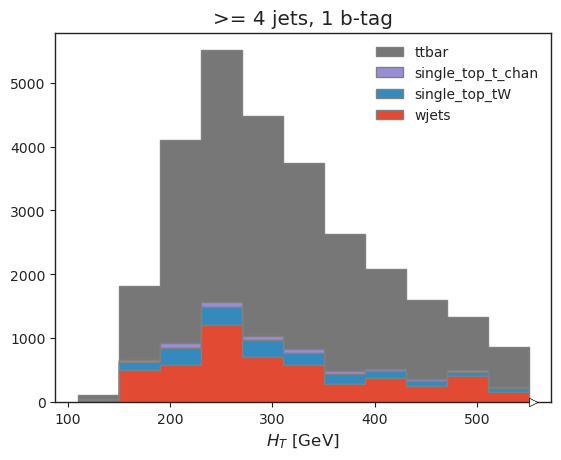

In [28]:
artists = full_histogram_4j1b[120j::hist.rebin(1), :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, 1 b-tag");

fig.savefig(fig_dir / "coffea_4j_1b.png", dpi=300)

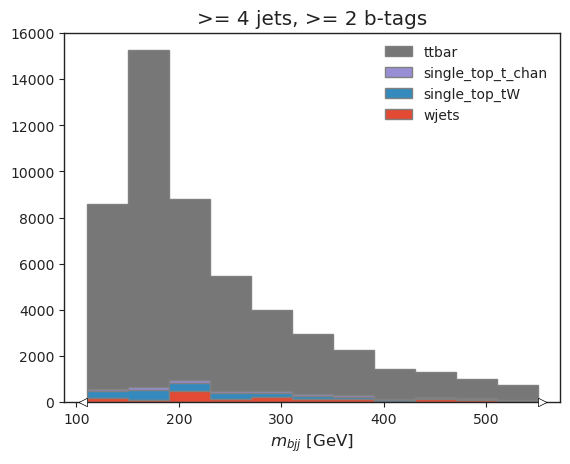

In [29]:
artists = full_histogram_4j2b[:, :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, >= 2 b-tags");

fig.savefig(fig_dir / "coffea_4j_2b.png", dpi=300)

**Note**: the histogram for $m_{bjj}$ looks slightly different from the one in [the main AGC repo](https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/ttbar_analysis_pipeline.ipynb). This is because we are already producing the histogram with the binning used for the statistical inference part, instead of rebenning after producing it.

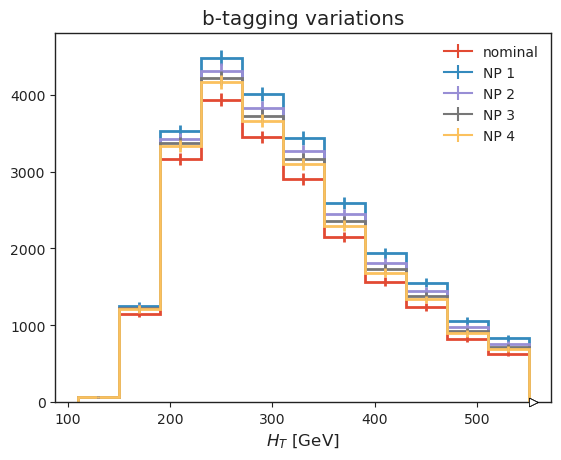

In [30]:
# b-tagging variations
ttbar_label = 'ttbar'
full_histogram_4j1b[120j::hist.rebin(1), ttbar_label, "nominal"].plot(label="nominal", linewidth=2)
full_histogram_4j1b[120j::hist.rebin(1), ttbar_label, "btag_var_0_up"].plot(label="NP 1", linewidth=2)
full_histogram_4j1b[120j::hist.rebin(1), ttbar_label, "btag_var_1_up"].plot(label="NP 2", linewidth=2)
full_histogram_4j1b[120j::hist.rebin(1), ttbar_label, "btag_var_2_up"].plot(label="NP 3", linewidth=2)
full_histogram_4j1b[120j::hist.rebin(1), ttbar_label, "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$H_T$ [GeV]")
plt.title("b-tagging variations");

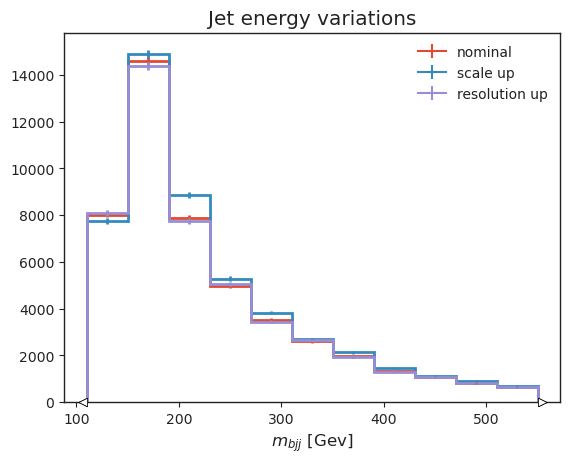

In [31]:
# jet energy scale variations
full_histogram_4j2b[:, ttbar_label, "nominal"].plot(label="nominal", linewidth=2)
full_histogram_4j2b[:, ttbar_label, "pt_scale_up"].plot(label="scale up", linewidth=2)
full_histogram_4j2b[:, ttbar_label, "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");

This is a plot you can compare to the one in the full AGC notebook — you'll notice they look the same. Success!